

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
В общем, я устала воевать, оставлю все как есть. Lesika aka Alena Petrova, скор на кагле 0.96918

In [1]:
!pip install -U torch torchvision

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:38tcmalloc: large alloc 1147494400 bytes == 0x559cac376000 @  0x7f6c90f9d615 0x559c481274cc 0x559c4820747a 0x559c4812a2ed 0x559c4821be1d 0x559c4819de99 0x559c481989ee 0x559c4812bbda 0x559c4819dd00 0x559c481989ee 0x559c4812bbda 0x559c4819a737 0x559c4821cc66 0x559c48199daf 0x559c4821cc66 0x559c48199daf 0x559c4821cc66 0x559c48199daf 0x559c4812c039 0x559c4816f409 0x559c4812ac52 0x559c4819dc25 0x559c481989ee 0x559c4812bbda 0x559c4819a737 0x559c481989ee 0x559c4812bbda 0x559c48199915 0x559c4812bafa 0x559c48199c0d 0x559c481989ee
     |████████████████████████████████| 881.9 MB 16 kB/s 
     |████████████████████████████████| 23.3 MB 54.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvisi

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:

!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=53a63e0da7bd49ab44c4c30c21b2eba241344ddec83d82a1451e158f46a8088a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:


import os
import PIL
print(PIL.PILLOW_VERSION)

os.environ['KAGGLE_USERNAME'] = 'lesika'
os.environ['KAGGLE_KEY'] = '9758aeb07bd1ff609f952d70504c4e9c'

!kaggle competitions download -c journey-springfield
!unzip -qq journey-springfield.zip

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  """


7.1.2
 99% 516M/521M [00:05<00:00, 127MB/s]
100% 521M/521M [00:05<00:00, 106MB/s]


In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
print([x for x in train_val_files])
print(len(train_val_files))


[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0006.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0007.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0008.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0009.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0010.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0011.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0012.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_s

In [9]:
!ls train

simpsons_dataset


In [10]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Dec 19 17:50:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [11]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [12]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

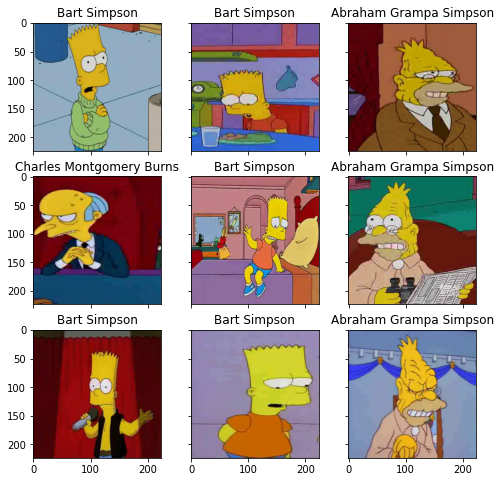

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [17]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [20]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
import numpy as np

In [23]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')


In [25]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=6, batch_size=125)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 2.7499444473016807


epoch:  17%|█▋        | 1/6 [02:44<13:42, 164.48s/it]


Epoch 001 train_loss: 2.7499     val_loss 2.1372 train_acc 0.2294 val_acc 0.4255
loss 1.8017514182834977


epoch:  33%|███▎      | 2/6 [05:27<10:55, 163.86s/it]


Epoch 002 train_loss: 1.8018     val_loss 1.6256 train_acc 0.5011 val_acc 0.5642
loss 1.3262045497127046


epoch:  50%|█████     | 3/6 [08:12<08:13, 164.37s/it]


Epoch 003 train_loss: 1.3262     val_loss 1.2946 train_acc 0.6288 val_acc 0.6527
loss 0.9865521734228133


epoch:  67%|██████▋   | 4/6 [10:56<05:28, 164.21s/it]


Epoch 004 train_loss: 0.9866     val_loss 1.0987 train_acc 0.7263 val_acc 0.7126
loss 0.7507380882648383


epoch:  83%|████████▎ | 5/6 [13:40<02:44, 164.08s/it]


Epoch 005 train_loss: 0.7507     val_loss 1.0218 train_acc 0.7875 val_acc 0.7323
loss 0.5794931946457461


epoch: 100%|██████████| 6/6 [16:24<00:00, 164.12s/it]


Epoch 006 train_loss: 0.5795     val_loss 0.9498 train_acc 0.8334 val_acc 0.7665


Построим кривые обучения

In [26]:
loss, acc, val_loss, val_acc = zip(*history)

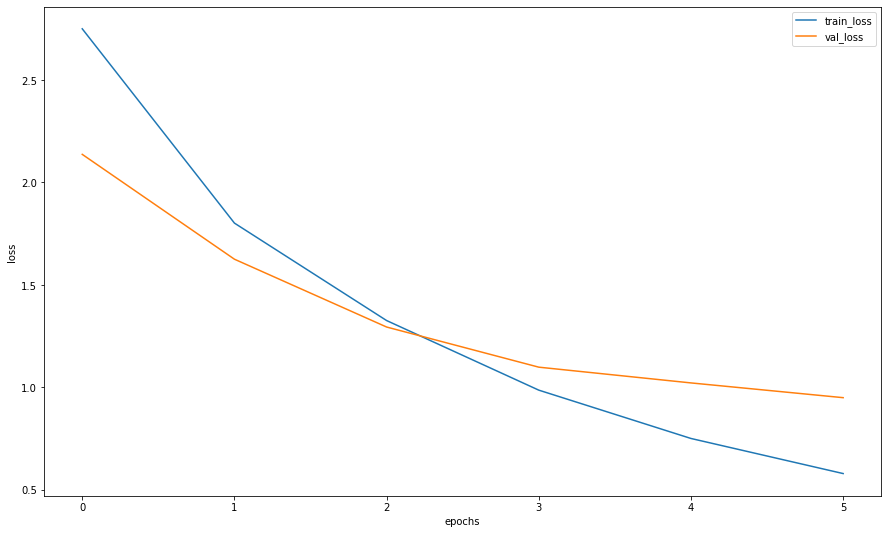

In [27]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [28]:
torch.cuda.empty_cache()

In [29]:
import torchvision.models as models
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs,n_classes)
resnet = resnet.to(DEVICE)
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [30]:
history = train(train_dataset, val_dataset, model=resnet, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7245664925125421


epoch:  10%|█         | 1/10 [03:50<34:33, 230.37s/it]


Epoch 001 train_loss: 0.7246     val_loss 0.9755 train_acc 0.8273 val_acc 0.7532
loss 3.6845633339385286


epoch:  20%|██        | 2/10 [07:35<30:16, 227.07s/it]


Epoch 002 train_loss: 3.6846     val_loss 3.1129 train_acc 0.1064 val_acc 0.1074
loss 3.114592362895985


epoch:  30%|███       | 3/10 [11:18<26:19, 225.59s/it]


Epoch 003 train_loss: 3.1146     val_loss 3.1035 train_acc 0.1067 val_acc 0.1068
loss 3.085896902110472


epoch:  40%|████      | 4/10 [15:02<22:29, 224.94s/it]


Epoch 004 train_loss: 3.0859     val_loss 3.0740 train_acc 0.1113 val_acc 0.1095
loss 3.0334548949891573


epoch:  50%|█████     | 5/10 [18:47<18:44, 224.90s/it]


Epoch 005 train_loss: 3.0335     val_loss 3.0194 train_acc 0.1170 val_acc 0.1146
loss 2.903505404987672


epoch:  60%|██████    | 6/10 [22:32<14:59, 224.77s/it]


Epoch 006 train_loss: 2.9035     val_loss 2.6886 train_acc 0.1594 val_acc 0.2415
loss 2.4218407493312233


epoch:  70%|███████   | 7/10 [26:16<11:14, 224.67s/it]


Epoch 007 train_loss: 2.4218     val_loss 2.1898 train_acc 0.3177 val_acc 0.3838
loss 1.864954128266292


epoch:  80%|████████  | 8/10 [30:00<07:28, 224.44s/it]


Epoch 008 train_loss: 1.8650     val_loss 1.6720 train_acc 0.4744 val_acc 0.5405
loss 1.4995186500803241


epoch:  90%|█████████ | 9/10 [33:43<03:43, 223.80s/it]


Epoch 009 train_loss: 1.4995     val_loss 1.4186 train_acc 0.5790 val_acc 0.6120
loss 1.2150430315823697


epoch: 100%|██████████| 10/10 [37:26<00:00, 224.63s/it]


Epoch 010 train_loss: 1.2150     val_loss 1.2700 train_acc 0.6603 val_acc 0.6469


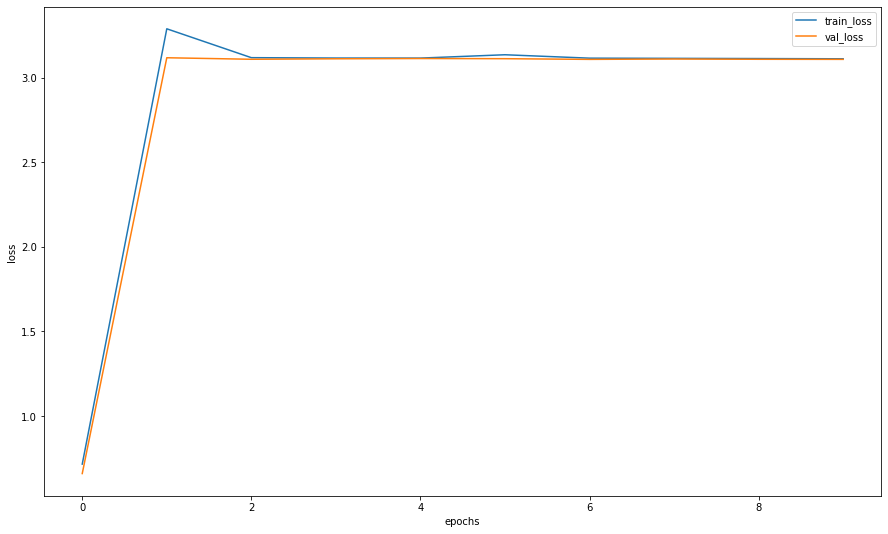

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [31]:

torch.save(resnet.state_dict(), "resnet.pth") 

In [33]:
# Пробуем дообучать
resnet = models.resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs,n_classes)
resnet.load_state_dict(torch.load("resnet.pth"))

<All keys matched successfully>

In [ ]:
resnet = resnet.to(DEVICE)
history = train(train_dataset, val_dataset, model=resnet, epochs=50, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.6462276601754935


epoch:  10%|█         | 1/10 [03:22<30:19, 202.18s/it]


Epoch 001 train_loss: 2.6462     val_loss 2.8376 train_acc 0.2958 val_acc 0.3756
loss 3.171155861270102


epoch:  20%|██        | 2/10 [06:40<26:41, 200.14s/it]


Epoch 002 train_loss: 3.1712     val_loss 2.9264 train_acc 0.1160 val_acc 0.1712
loss 2.7663429888412976


epoch:  30%|███       | 3/10 [09:59<23:17, 199.60s/it]


Epoch 003 train_loss: 2.7663     val_loss 2.4675 train_acc 0.2039 val_acc 0.3023
loss 2.2838635616328613


epoch:  40%|████      | 4/10 [13:18<19:54, 199.08s/it]


Epoch 004 train_loss: 2.2839     val_loss 2.0691 train_acc 0.3572 val_acc 0.4339
loss 1.802375696504091


epoch:  50%|█████     | 5/10 [16:35<16:32, 198.54s/it]


Epoch 005 train_loss: 1.8024     val_loss 1.6296 train_acc 0.4999 val_acc 0.5577
loss 1.4637037764856697


epoch:  60%|██████    | 6/10 [19:53<13:13, 198.43s/it]


Epoch 006 train_loss: 1.4637     val_loss 1.3983 train_acc 0.5939 val_acc 0.6150
loss 1.169299908857967


epoch:  70%|███████   | 7/10 [23:11<09:54, 198.14s/it]


Epoch 007 train_loss: 1.1693     val_loss 1.2057 train_acc 0.6710 val_acc 0.6800
loss 1.0016794364629593


epoch:  80%|████████  | 8/10 [26:29<06:36, 198.11s/it]


Epoch 008 train_loss: 1.0017     val_loss 1.0353 train_acc 0.7176 val_acc 0.7186
loss 0.8122041969741558


epoch:  90%|█████████ | 9/10 [29:47<03:17, 197.98s/it]


Epoch 009 train_loss: 0.8122     val_loss 0.9057 train_acc 0.7660 val_acc 0.7570
loss 0.6675251632467547


epoch: 100%|██████████| 10/10 [33:05<00:00, 198.55s/it]


Epoch 010 train_loss: 0.6675     val_loss 0.8762 train_acc 0.8060 val_acc 0.7707


### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,1000, 200)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [37]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [38]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [39]:
from sklearn.metrics import f1_score

f1_score(actual_labels, list(y_pred), average='weighted')


0.818132183908046

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

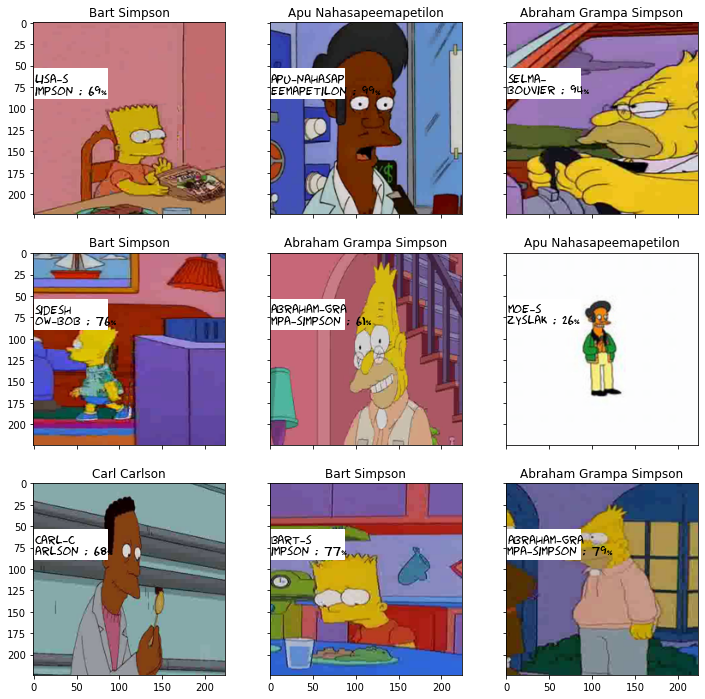

In [40]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=12, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [41]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [42]:
# my code
print(preds[:5])

['nelson_muntz' 'bart_simpson' 'ned_flanders' 'chief_wiggum'
 'apu_nahasapeemapetilon']


In [43]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_data	       testset
journey-springfield.zip      resnet.pth		sample_submission.csv  train


In [45]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [46]:
my_submit.to_csv('/content/simple_cnn_baseline_2021_12_19.csv', index=False)

In [47]:
print(actual_labels)
print(preds_class)

[4, 2, 6, 4, 4, 6, 2, 6, 6, 4, 0, 4, 0, 6, 4, 4, 4, 2, 4, 6, 2, 6, 0, 4, 0, 0, 2, 2, 4, 0, 4, 2, 4, 4, 4, 0, 0, 2, 2, 6, 0, 0, 4, 0, 6, 6, 4, 2, 0, 2, 0, 4, 0, 4, 4, 0, 0, 6, 4, 5, 6, 1, 6, 4, 2, 6, 6, 4, 6, 0, 4, 0, 2, 0, 4, 2, 2, 6, 4, 0, 4, 4, 6, 6, 6, 2, 4, 4, 4, 6, 0, 0, 0, 6, 4, 4, 6, 6, 4, 6, 6, 0, 0, 2, 3, 6, 2, 0, 4, 4, 0, 0, 4, 6, 6, 6, 4, 0, 4, 2, 4, 2, 2, 2, 2, 0, 4, 6, 4, 1, 4, 0, 6, 0, 0, 0, 6, 4, 4, 3, 2, 6, 0, 4, 4, 6, 2, 4, 0, 6, 3, 4, 0, 0, 4, 6, 4, 0, 2, 4, 4, 0, 5, 2, 0, 4, 2, 6, 4, 6, 6, 6, 4, 4, 4, 4, 6, 6, 6, 4, 0, 0, 0, 4, 6, 4, 6, 4, 4, 6, 6, 0, 4, 1, 4, 2, 2, 2, 2, 0]
['bart_simpson', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'bart_simpson', 'bart_simpson', 'bart_simpson', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'charles_montgomery_burns', 'homer_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'abraham_grampa_simpson', 'homer_simpson', 'bart_simpson', 'bart_simpson', 'bart_simpson', 'apu_nahasapeemapetilon', 'homer_simpson', 'prin

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
